In [1]:
from scipy.misc import comb
import math

In [3]:
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) *
             error ** k *
             (1 - error) ** (n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)


In [6]:
ensemble_error(11, 0.25)

0.034327507019042969

In [8]:
import numpy as np

In [9]:
error_range = np.arange(0.0, 1.01, 0.01)

In [10]:
ens_errors = [ensemble_error(11, error) for error in error_range]

In [11]:
import matplotlib.pyplot as plt

In [12]:
plt.plot(error_range, ens_errors, label="Ensemble error", linewidth=2)

In [13]:
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

In [14]:
plt.xlabel('Base Error')

In [15]:
plt.ylabel('Base/Ensemble error')

In [16]:
plt.legend(loc='upper left')

In [17]:
plt.grid()

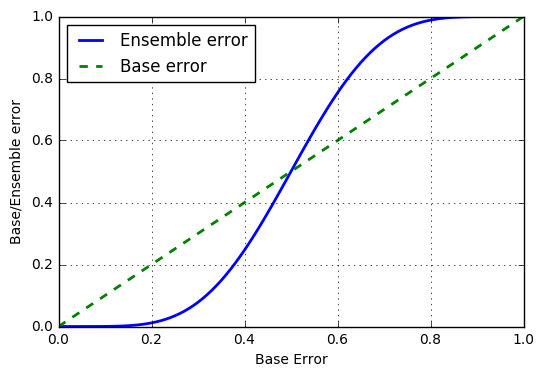

In [18]:
plt.show()

In [19]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


In [65]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {k: v for k, v in _name_estimators(classifiers)}
        
        if vote not in ('classlabel', 'probability'):
            raise ValueError("Invalid choice for vote.")
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            return np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, wights=self.weights)),
                                          axis=1, arr=predictions)
            maj_vote = self.labelenc_.inverse_transform(maj_vote)
            return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        
        out = self.named_classifiers.copy()
        for name, step in self.named_classifiers.items():
            for k, v in step.get_params(deep=True).items():
                out['%s__%s' % (name, k)] = v
        return out


In [49]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [23]:
iris = datasets.load_iris()

In [25]:
X, y = iris.data[50:, [1, 2]], iris.target[50:]

In [26]:
le = LabelEncoder()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [30]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [50]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [51]:
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

In [52]:
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

In [53]:
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(scores.mean(), scores.std(), label)

0.916666666667 0.20069324298 Logistic Regression
0.916666666667 0.153659074288 Decision Tree
0.933333333333 0.104083299973 KNN


In [66]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

In [67]:
clf_labels += ['Majority Voting']

In [68]:
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [69]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(scores.mean(), scores.std(), label)

0.916666666667 0.20069324298 Logistic Regression
0.916666666667 0.153659074288 Decision Tree
0.933333333333 0.104083299973 KNN
0.966666666667 0.1 Majority Voting


In [70]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

In [71]:
from sklearn.grid_search import GridSearchCV

/home/hirokiky/dev/pydata_now/env/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [72]:
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

In [74]:
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')

In [75]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [78]:
for params, mean_score, scores in grid.grid_scores_:
    print(mean_score, scores.std() / 2, params)

0.9666666666666667 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.9666666666666667 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.0 0.0 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.9666666666666667 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.9666666666666667 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.0 0.0 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [79]:
print(grid.best_params_)

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


In [80]:
print(grid.best_score_)

1.0


# 7.4

In [81]:
import pandas as pd

In [82]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [83]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phonols', 'Proanthocyanins', 'Color intensity',
                  'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [84]:
df_wine = df_wine[df_wine['Class label'] != 1]

In [85]:
y = df_wine['Class label'].values

In [86]:
X = df_wine[['Alcohol', 'Hue']].values

In [87]:
le = LabelEncoder()

In [88]:
y = le.fit_transform(y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [90]:
from sklearn.ensemble import BaggingClassifier

In [91]:
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=None,
                             random_state=1)

In [92]:
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

In [93]:
from sklearn.metrics import accuracy_score

In [94]:
tree = tree.fit(X_train, y_train)

In [95]:
y_train_pred = tree.predict(X_train)

In [96]:
y_test_pred = tree.predict(X_test)

In [97]:
tree_train = accuracy_score(y_train, y_train_pred)

In [98]:
tree_test = accuracy_score(y_test, y_test_pred)

In [99]:
tree_train, tree_test

(1.0, 0.83333333333333337)

In [100]:
bag = bag.fit(X_train, y_train)

In [101]:
y_train_pred = bag.predict(X_train)

In [102]:
y_test_pred = bag.predict(X_test)

In [103]:
bag_train = accuracy_score(y_train, y_train_pred)

In [104]:
bag_test = accuracy_score(y_test, y_test_pred)

In [105]:
bag_train, bag_test

(1.0, 0.89583333333333337)

In [106]:
from sklearn.ensemble import AdaBoostClassifier

In [123]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)

In [124]:
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)

In [125]:
tree = tree.fit(X_train, y_train)

In [126]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
tree_train, tree_test

(0.84507042253521125, 0.85416666666666663)

In [127]:
ada = ada.fit(X_train, y_train)

In [128]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
ada_train, ada_test

(1.0, 0.875)